In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import numpy as np
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

In [3]:
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=_URL, extract=True)

In [4]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

C:\Users\everl\.keras\datasets
C:\Users\everl\.keras\datasets/cats_and_dogs_filtered
C:\Users\everl\.keras\datasets/cats_and_dogs_filtered/train
C:\Users\everl\.keras\datasets/cats_and_dogs_filtered/train/cats
C:\Users\everl\.keras\datasets/cats_and_dogs_filtered/train/dogs
C:\Users\everl\.keras\datasets/cats_and_dogs_filtered/validation
C:\Users\everl\.keras\datasets/cats_and_dogs_filtered/validation/cats
C:\Users\everl\.keras\datasets/cats_and_dogs_filtered/validation/dogs


The dataset we have downloaded has the following directory structure.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

We can list the directories with the following terminal command:

In [5]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [6]:
base_dir

'C:\\Users\\everl\\.keras\\datasets\\cats_and_dogs_filtered'

In [7]:
train_dir

'C:\\Users\\everl\\.keras\\datasets\\cats_and_dogs_filtered\\train'

In [8]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [9]:
train_cats_dir

'C:\\Users\\everl\\.keras\\datasets\\cats_and_dogs_filtered\\train\\cats'

In [10]:
num_cats_tr =len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))
num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)
print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("-------------------------------------------")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
-------------------------------------------
Total training images: 2000
Total validation images: 1000


## Setting Model Parameters

In [11]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done using the class **tf.keras.preprocessing.image.ImageDataGenerator**.

We can set this up in a couple of lines of code.

In [12]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

After defining our generators for training and validation images, **flow_from_directory** method will load images from the disk, apply rescaling, and resize them using single line of code.

In [13]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


### * Cada pasta no diretorio o tensoflow considera como uma classe. Dog & Cat = 2 folders

In [14]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


In [15]:
sample_training_images, _ = next(train_data_gen) 

In [16]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

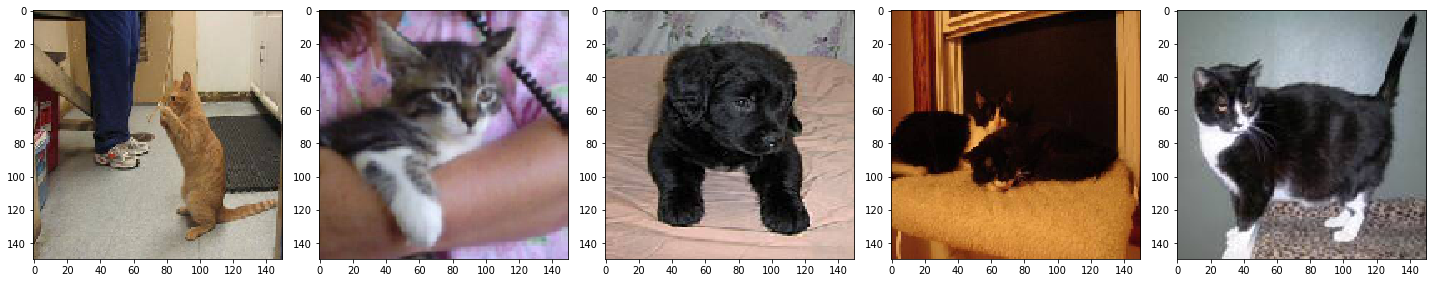

In [17]:
plotImages(sample_training_images[:5])  # Plot images 0-4

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [21]:
EPOCHS = 100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Train for 20 steps, validate for 10 steps
Epoch 1/100
20/20 [==============================] - 17s 867ms/step - loss: 0.7915 - accuracy: 0.4945 - val_loss: 0.6928 - val_accuracy: 0.5010
Epoch 2/100
20/20 [==============================] - 6s 313ms/step - loss: 0.6927 - accuracy: 0.5110 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 3/100
20/20 [==============================] - 6s 316ms/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/100
20/20 [==============================] - 6s 314ms/step - loss: 0.6908 - accuracy: 0.5150 - val_loss: 0.6855 - val_accuracy: 0.5520
Epoch 5/100
20/20 [==============================] - 6s 319ms/step - loss: 0.6877 - accuracy: 0.5330 - val_loss: 0.6875 - val_accuracy: 0.6400
Epoch 6/100
20/20 [==============================] - 7s 330ms/step - loss: 0.6856 - accuracy: 0.5335 - val_loss: 0.6959 - val_accuracy: 0.5120
Epoch 7/100
20/20 [==============================] - 7s 333ms/step - loss: 0.6731 - accuracy: 0.582

Epoch 57/100
20/20 [==============================] - 6s 320ms/step - loss: 4.5387e-05 - accuracy: 1.0000 - val_loss: 2.3179 - val_accuracy: 0.7280
Epoch 58/100
20/20 [==============================] - 6s 323ms/step - loss: 4.2994e-05 - accuracy: 1.0000 - val_loss: 2.3267 - val_accuracy: 0.7270
Epoch 59/100
20/20 [==============================] - 6s 318ms/step - loss: 4.0928e-05 - accuracy: 1.0000 - val_loss: 2.3351 - val_accuracy: 0.7280
Epoch 60/100
20/20 [==============================] - 6s 322ms/step - loss: 3.9080e-05 - accuracy: 1.0000 - val_loss: 2.3443 - val_accuracy: 0.7280
Epoch 61/100
20/20 [==============================] - 6s 318ms/step - loss: 3.7150e-05 - accuracy: 1.0000 - val_loss: 2.3512 - val_accuracy: 0.7270
Epoch 62/100
20/20 [==============================] - 6s 318ms/step - loss: 3.5431e-05 - accuracy: 1.0000 - val_loss: 2.3590 - val_accuracy: 0.7270
Epoch 63/100
20/20 [==============================] - 6s 321ms/step - loss: 3.3973e-05 - accuracy: 1.0000 - val_

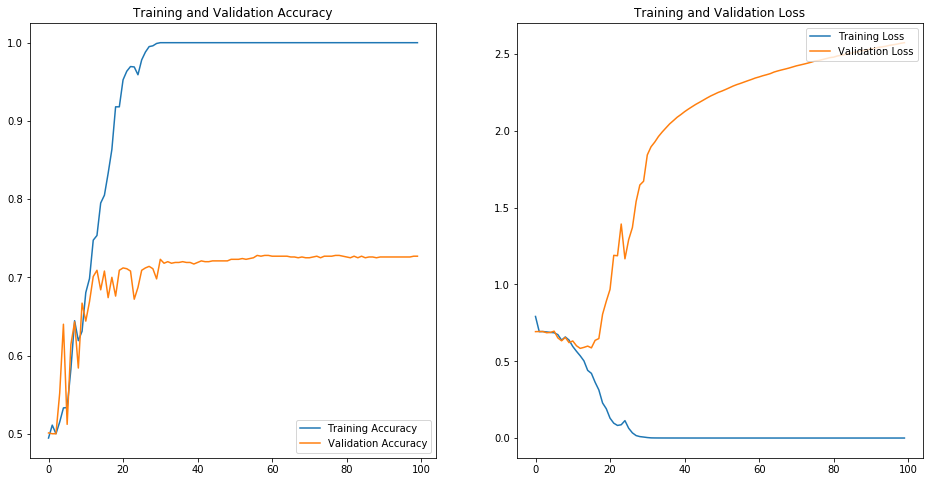

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

Overfitting: Validation aumenta e training loss cai.